In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

from IPython.display import clear_output
from numpy.polynomial import Polynomial
from matplotlib.gridspec import GridSpec
from numba import njit, prange
from scipy.optimize import minimize, curve_fit
from prototypefive import *

In [8]:
with open("data.json") as f:
    POSITION, LENGTH_OLD, BES1_RAW, CPD, ROT3, AUXIN = map(np.array, json.load(f).values())

# Define time to position and position to time functions
time_to_position = np.poly1d(np.polyfit(POSITION[:, 0], POSITION[:, 1], 4))
position_to_time = np.poly1d(np.polyfit(POSITION[:, 1], POSITION[:, 0], 4))

# Define the time step and time vector
STEP = 0.01
vT = np.arange(0, 18 + STEP, STEP)
vP = position_to_time(vT)

# Preprocess the length data
LENGTH_RAW = pd.read_csv(f"data/trichoblast-areas.csv")
LENGTH_RAW = LENGTH_RAW.set_index("Cell Position")
LENGTH, N = parse_mutant_data("WT-", LENGTH_RAW, 2)

def process_length_data(data):

    # Filter the data to only include positions between 150 and 600um
    idx = np.where((data[:, 0] > 150) & (data[:, 0] < 600))
    data = data[idx]
    
    # Transform the data to be in terms of time
    data[:, 0] = position_to_time(data[:, 0])
    return data

LENGTH = process_length_data(LENGTH)

In [112]:
# Compute the RMSE of a trial run given a predicted BR signalling level vS
@njit
def RMSE(vL, data):

    # Compute the residuals
    predicted = np.interp(LENGTH[:, 0], vT, vL)
    observed = data
    residuals = predicted - observed

    # Find the residual sum of squares and RMSE
    rss = np.sum(np.square(residuals))
    rmse = np.sqrt(rss / np.size(data))
    return rmse, predicted

# Function for computing the bound receptors
@njit
def RB(B, R_T, K_D):
    A = B + R_T + K_D
    return (A - np.sqrt(A ** 2 - 4 * R_T * B)) / 2

# Run a complete simulation
@njit
def simulate_cell(data, params):

    s_0, s_in, s_out = 0.0599, 0.0586, 0
    g_0, g_P, g_B = params
    vB = get_br(vP, CPD, ROT3)
    vRB = RB(vB, 62, 10)

    l, vL = g_0, np.empty(vRB.size)
    s, vS = s_0, np.empty(vRB.size)
    
    for i in prange(vRB.size):
        
        vL[i] = l
        vS[i] = s

        l += (g_P + g_B * s) * l * STEP
        s += (s_in * vRB[i] - s_out * s) * STEP

    rmse, predicted = RMSE(vL, data)
    return vL, rmse, predicted

In [108]:
def fit_model(data, log):

    # Set initial parameter values and bounds
    params = np.array([5, 0.5, 0.5])
    bounds = np.array([[0, 10], [0, 1], [0, 1]])

    # Create a cost function
    cost = lambda params : simulate_cell(data, params)[1]

    # Find the parameters of best fit
    fit = minimize(
        cost, 
        params, 
        method = "trust-constr",
        bounds = bounds, 
        options = {"maxiter": 1000}
    )

    # Run a simulation with the optimal parameters
    vL, rmse, predicted = simulate_cell(LENGTH[:, 1], fit.x)

    # Log the simulation
    if log: 
        print("Success: ", fit.success, fit.message)
        print("Params: ", fit.x)
        print("Error: ", rmse)
        
    return vL, rmse, predicted, fit.x

vL, rmse, predicted, optimal_params = fit_model(LENGTH[:, 1], True)

Success:  True `gtol` termination condition is satisfied.
Params:  [8.13476873e+00 9.35911584e-08 2.18123172e-01]
Error:  8.548128457700926


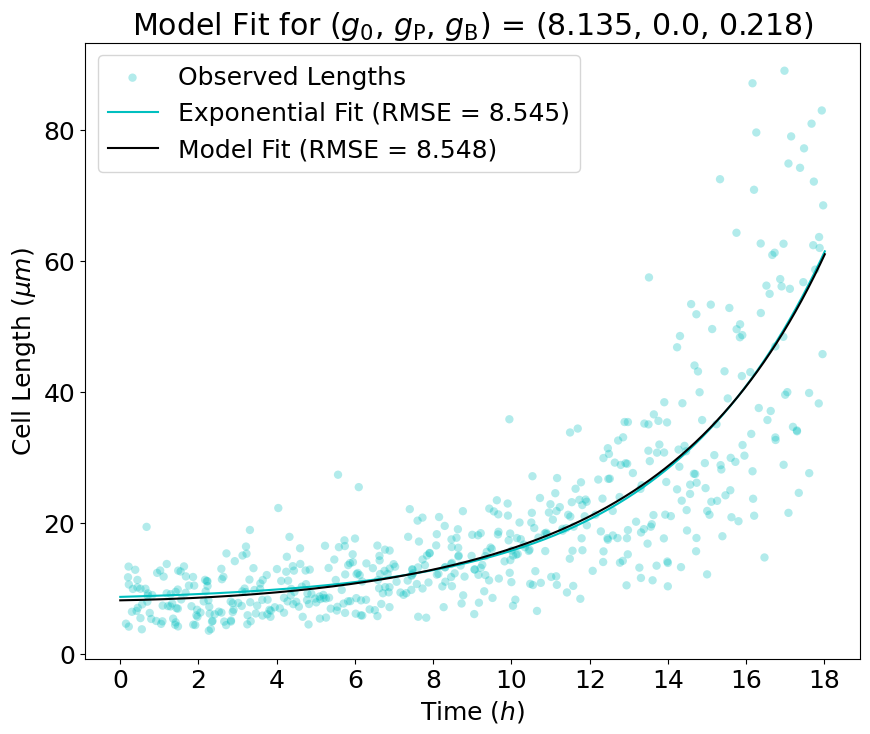

In [111]:
# Fit an exponential function to compare with and compute its RMSE
f = lambda x, A, B, C : A + B * np.exp(C * x)
popt, pcov = curve_fit(f, LENGTH[:, 0], LENGTH[:, 1])
exp_data = f(vT, *popt)
exp_rmse, exp_predictions = RMSE(exp_data, LENGTH[:, 1])

# Plot the raw data, the cubic interpolation, the model fit
plt.scatter(LENGTH[:, 0], LENGTH[:, 1], color = "c", label = "Observed Lengths", alpha = 0.3, edgecolors = "none")
plt.plot(vT, exp_data, color = "c", label = f"Exponential Fit (RMSE = {exp_rmse:.3f})")
plt.plot(vT, vL, color = "k", label = f"Model Fit (RMSE = {rmse:.3f})")

# Add axis labels, title, etc.
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 8)

plt.xlabel(r"Time ($h$)")
plt.ylabel(r"Cell Length ($\mu m$)")
plt.xticks(np.arange(0, 20, 2))
plt.title(r"Model Fit for ($g_0$, $g_\text{P}$, $g_\text{B}$) = " + f"{tuple(round(x, 3) for x in optimal_params)}")

plt.legend()
plt.savefig("img/prototype-5c-best-fit.png", bbox_inches = "tight")

## Error Shuffling

In [114]:
# Generate N shuffled BES1 datasets given the original data and a vector of predictions
def shuffle_errors(N, observed, predicted):

    errors = (predicted - observed) / observed
    shuffled_data = np.empty((N, observed.size))
    for i in range(N):
        shuffled_errors = np.random.permutation(errors)
        shuffled_observations = observed + (observed * shuffled_errors)
        shuffled_data[i, :] = shuffled_observations
        
    return shuffled_data

# Produce a scatterplot of the optimal parameters after shuffling
def compute_confidence_intervals(N, observed, predicted):
    
    shuffled_data = shuffle_errors(N, LENGTH[:, 1], predicted)
    distribution = np.empty((N, 3))
    for i in range(N):
        if i % 10 == 9:
            clear_output(wait = True)
            print(f"Fitting model {i + 1}")
        vS, rss, predicted, optimal_params = fit_model(shuffled_data[i], False)
        distribution[i, :] = optimal_params

    return distribution

distribution = compute_confidence_intervals(1000, LENGTH[:, 1], predicted)

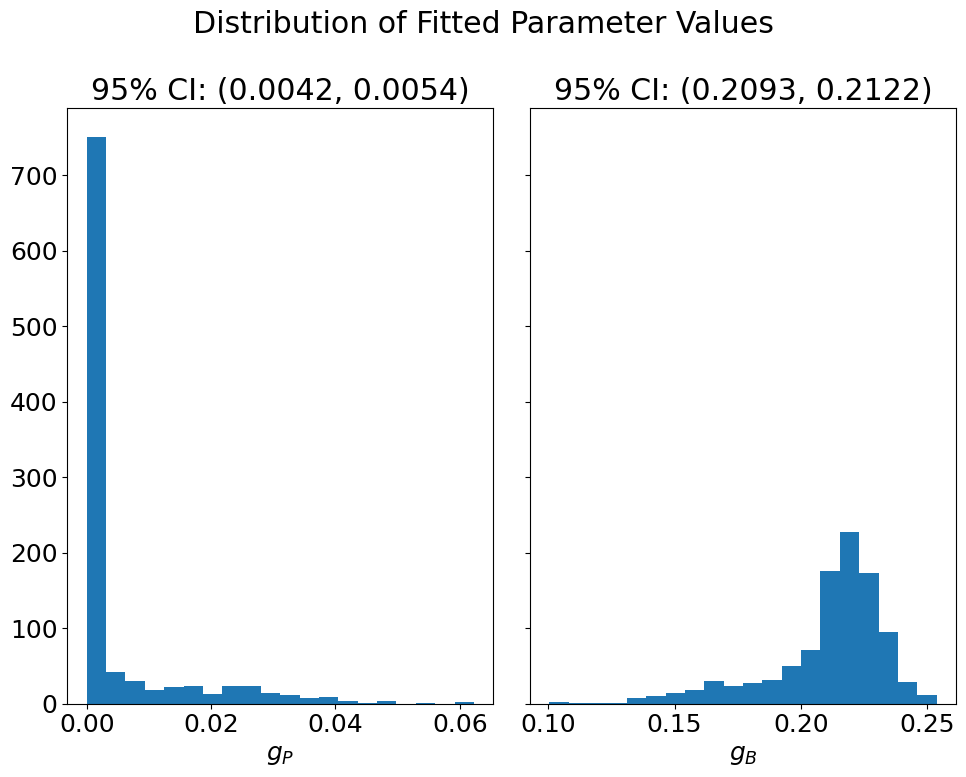

In [116]:
# Compute the confidence intervals for g_P and g_B
import scipy.stats as st

def confidence_interval(a, pct):
    return st.t.interval(pct, len(a)-1, loc=np.mean(a), scale=st.sem(a))

gp_interval = confidence_interval(distribution[:, 1], 0.95)
gb_interval = confidence_interval(distribution[:, 2], 0.95)

# Plot a histogram of the g_P and g_B values
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, tight_layout=True)

ax1.hist(distribution[:, 1], bins=20)
ax1.set_xlabel(r"$g_P$")
ax1.set_title(f"95% CI: {tuple(round(x, 4) for x in gp_interval)}")

ax2.hist(distribution[:, 2], bins=20)
ax2.set_xlabel(r"$g_B$")
ax2.set_title(f"95% CI: {tuple(round(x, 4) for x in gb_interval)}")

fig.suptitle("Distribution of Fitted Parameter Values")
fig.savefig("img/prototype-5c-uncertainty.png")

## Heatmap

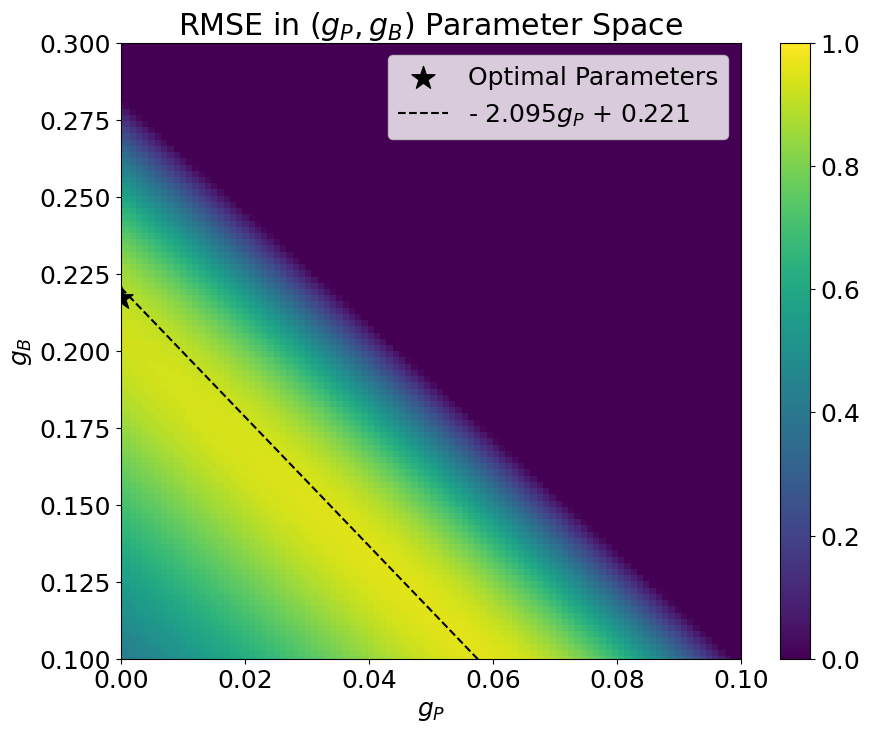

In [90]:
# Create a lattice of parameter values
vGP  = np.linspace(0, 0.1, 100).tolist()
vGB = np.linspace(0.1, 0.3, 100).tolist()

error_space = np.empty((100, 100))
for i, g_P in enumerate(vGP):
    for j, g_B in enumerate(vGB):
        result = simulate_cell(LENGTH[:, 1], [8.225, g_P, g_B])
        error_space[i, j] = result[1]

# Plot the heatmap and the optimal parameter values
plt.pcolor(vGP, vGB, error_space, cmap="viridis_r", vmin = 8, vmax = 20)
plt.scatter(0, 0.217, c = "k", marker = "*", s = 300, label = "Optimal Parameters")

# Fit a linear regression to the distribution of parameter values and plot it
polyfit = Polynomial.fit(distribution[:, 0], distribution[:, 1], deg = 1).convert()
ts = np.linspace(0, 1, 1000)
plt.plot(ts, polyfit(ts), 'k--', label = fr"- {abs(polyfit.coef[1]):.3f}$g_P$ + {polyfit.coef[0]:.3f}")

# Other plot config stuff goes here
plt.xlabel(r"$g_{P}$")
plt.ylabel(r"$g_{B}$")
plt.xlim((0, 0.1))
plt.ylim((0.1, 0.3))
plt.colorbar()
plt.legend()
plt.title(r"RMSE in $(g_P, g_B)$ Parameter Space")
plt.savefig("img/prototype-5c-model-heatmap.png")